# Galaxy Zoo Dataset

Galaxy Zoo is a citizen science project for the morphological classification of galaxies from their RGB image. They provide their results as part of a kaggle competition at [www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/)
Here we download this data and perform a vanilla classification task.

In order to load the data directly from kaggle to the colab notebook, you have to be registered in kaggle and first download an API file from their homepage: go to [www.kaggle.com](https://www.kaggle.com), navigate to you profile info (click your picture in top right and then click "Your Profile"). Click "Account", scroll down to "API" and click "Generate new API token". This will download a "kaggle.json" file. 
Start the notebook in colab. On the left, navigate to files and upload the "kaggle.json" file. Once that is done, you can continue with running the cell below that will automatically download the data for you.
A more detailed description with pictures can be found [here](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)


In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

DATADIR = "./data"

file_x = "images_training_rev1.zip"
file_y = "training_solutions_rev1.zip"
competition = "galaxy-zoo-the-galaxy-challenge"

!kaggle competitions download -f $file_x $competition
!kaggle competitions download -f $file_y $competition
! mkdir $DATADIR
! unzip -qq /content/$file_x -d $DATADIR
! unzip -qq /content/$file_y -d $DATADIR




100% 791M/792M [00:07<00:00, 157MB/s]
100% 792M/792M [00:07<00:00, 115MB/s]
100% 4.63M/4.63M [00:00<00:00, 39.6MB/s]



In [2]:
# the data can now be found in 
images_folder = DATADIR + "/images_training_rev1/"
labels_file = DATADIR + "/training_solutions_rev1.csv"



The data consists of 424x424 px RGB images together with a vector of 37 labels as float values. The labels were obtained asking citizen scientists a number of questions in a hierarchical order, the labels are obtained as the amount of people giving the same answer. More details can be found at [www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/)

# Dataloader

In [3]:
from glob import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Module, Sequential, Linear, ReLU, Flatten, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.dataloader import default_collate
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import torchvision.models as models
from pandas import read_csv
from sklearn.model_selection import train_test_split
from PIL import Image

Since training takes a lot of time otherwise, you should use cuda. On Colab, you can do this by clicking "Runtime" (next to "Tools" in top-left) and than "Change Runtime type" and choose GPU.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:

def get_labels() -> torch.Tensor:
    df_galaxy_labels =  read_csv(labels_file)
    labels = df_galaxy_labels[df_galaxy_labels.columns[1:]].values
    labels = torch.from_numpy(labels).float()
    return labels


class DataSet(Dataset):
    def __init__(self):
        self.path_images = images_folder
        file_list = glob(self.path_images + "*")
        file_list.sort()
        df_galaxy_labels =  read_csv(labels_file)
        labels_train = df_galaxy_labels[df_galaxy_labels.columns[1:]].values
        labels_train = torch.from_numpy(labels_train).float()
        labels = get_labels()
        self.data = []
        for file, label in zip(file_list, labels):
            self.data.append([file, label])

        self.augment = Compose([
            CenterCrop(207),  ## galaxy is in the center of the image
            Resize((64,) * 2),  ## reduce size to improve speed
            ToTensor(),
        ])

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        file, label = self.data[index]
        img = Image.open(file)
        img = self.augment(img)
        return img, label

class MakeDataLoader:
    def __init__(self, test_size=0.1, random_state=2):
        self.dataset = DataSet()
        train_idx, test_idx = train_test_split(list(range(len(self.dataset))), train_size=1-test_size, test_size=test_size, random_state=random_state)

        indices = torch.randperm(len(train_idx))
        self.dataset_train = Subset(self.dataset, np.array(train_idx)[indices])
        self.dataset_test = Subset(self.dataset, test_idx)
        
        self.collate_fn = lambda x: list(map(lambda o: o.to(device), default_collate(x)))


    def get_data_loader_full(self, batch_size=64, shuffle=True, **kwargs) -> DataLoader:
        return DataLoader(self.dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True, collate_fn=self.collate_fn, **kwargs)

    def get_data_loader_train(self, batch_size=64, **kwargs) -> DataLoader:
        return DataLoader(self.dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=self.collate_fn, **kwargs)

    def get_data_loader_test(self, batch_size=64, **kwargs) -> DataLoader:
        return DataLoader(self.dataset_test, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=self.collate_fn, **kwargs)


# Data Investigation

Here we only show a particular example of a galaxy image together with the labels.

tensor([[0.9320, 0.0230, 0.0450, 0.0000, 0.0230, 0.0000, 0.0230, 0.0000, 0.0230,
         0.0000, 0.0000, 0.0230, 0.0000, 0.0480, 0.9520, 0.7726, 0.1594, 0.0000,
         0.0000, 0.0000, 0.0240, 0.0000, 0.0240, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0')


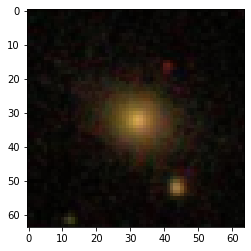

In [7]:
make_data_loader = MakeDataLoader()

data_loader = make_data_loader.get_data_loader_full(batch_size=1)

for image, label in data_loader:
    plt.imshow(image[0].cpu().permute(1, 2, 0))
    print(label)
    break

# Modelling
We make a small test using all but the last layer of the ResNet-18 architecture, provided by the torchvision package.

In [8]:
class Classifier(Module):
    def __init__(self):
        super(Classifier, self).__init__()
        resnet = models.resnet18(pretrained=False)
        self.conv = Sequential(
            *(list(resnet.children())[:-1]),
            Flatten(),
        )
        self.dense = Sequential(
            Linear(512, 37),
            ReLU()
        )

    def forward(self, images):
        x = self.conv(images)
        labels = self.dense(x)
        return labels


def train(dataloader, model, loss_fn, optimizer):
    for images, labels in tqdm(dataloader, desc="Training"):
        pred = model(images)
        loss = loss_fn(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

@torch.no_grad()
def test(dataloader, model, loss_fn, is_test=True, batches=1):
    full_loss = 0
    for batch, (images, labels) in tqdm(enumerate(dataloader), desc="Testing"):
        pred = model(images)
        loss = loss_fn(pred, labels)
        full_loss += loss.item()
        if batch + 1 == batches:
            break
    full_loss /= batch + 1
    print(f"{'Test' if is_test else 'Train'} loss: {full_loss:>8f}")
    return full_loss    

In [13]:
batch_size = 64
learning_rate = 1e-4

model = Classifier().to(device)
make_data_loader = MakeDataLoader()
train_loader = make_data_loader.get_data_loader_train(batch_size=batch_size)
val_loader = make_data_loader.get_data_loader_test(batch_size=batch_size)

loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)


In [16]:
epochs = 2
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    loss = test(train_loader, model, loss_fn, is_test=False)
    train_loss.append(loss)
    loss = test(val_loader, model, loss_fn, batches=10)
    test_loss.append(loss)
    print("\n")
print("Done!")

Epoch 1
-------------------------------


Testing: 0it [00:00, ?it/s]


Train loss: 0.026293


Testing: 9it [00:02,  3.75it/s]


Test loss: 0.025268


Epoch 2
-------------------------------


Testing: 0it [00:00, ?it/s]


Train loss: 0.027551


Testing: 9it [00:02,  3.77it/s]

Test loss: 0.024007


Done!


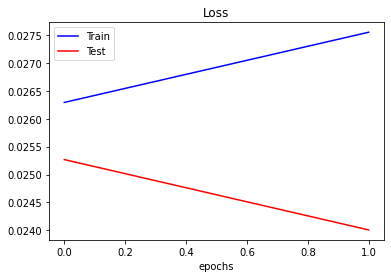

In [18]:
plt.plot(np.arange(epochs), train_loss, 'b', label="Train")
plt.plot(np.arange(epochs), test_loss, 'r', label="Test")
plt.title("Loss")
plt.xlabel("epochs")
plt.legend()